<a href="https://colab.research.google.com/github/dannyjammooa/PHY-989-Final-Project/blob/main/LM_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cmath
import numpy.linalg as LA
from scipy.sparse import diags
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as integrate
import scipy.special as special
import math
pi=np.pi

In [ ]:
def chi(V,E,omega):
  return (V/E)*(omega-1)

def Vp(E,omega,chi):
  return (chi*E)/(omega-1)

def sig(omega):
  return np.exp(-1j*np.pi*(omega/2))

###############Quasi Spin####################
def eigen(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  return E*np.diag(m)

def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=complex)
  right = np.zeros(len(m)-2,dtype=complex)
  diag = np.zeros(len(m),dtype=complex)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1))
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray()

def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H)
  return e,H

############Hartee Fock##############
def E_HF(x,E,omega):
  if x < 1:
    EHF = -(omega/2)*E
  elif x >= 1:
    EHF = -(omega/4)*E*(x+(1/x))
  return EHF

############PAV###############
def PAV(x,E,omega,state):
  if x < 1:
    cos = 1
    H= 1
    EN = 1
  elif x >= 1:
    cos = 1/x
    t2 =(x/2)*(x**2-1)
    t1=1/x
    H = (t1**omega)*((1/t1)+(x/2)*(x**2-1))
    EN = (1/2)*(x+(1/x))
  if state == 'ground': 
    bot = 1+(sig(omega)**2)*(cos**omega)
    top = (-omega*E/2)*(EN+(sig(omega)**2)*H)
  elif state == 'excited':
    bot = 1-(sig(omega)**2)*(cos**omega)
    top = (-omega*E/2)*(EN-(sig(omega)**2)*H)
  return top/bot

#############VAP#############
#Ground State
def VAPG(t):
  a = (1-abs(t)**2)/(1+abs(t)**2)
  H = (-omega*E/2)*(a**omega)*((1/a)+(2*x*t**2)/(1-abs(t)**2)**2)
  EN = (omega*E/2)*((abs(t)**2-1)/(abs(t)**2+1)-((2*x*t**2)/(abs(t)**2+1)**2))

  cos = -(abs(t)**2-1)/(abs(t)**2+1)
  bot = 1+sig(omega)**2*cos**omega
  top = EN+(sig(omega)**2)*H
  return (top/bot).real

#Excited State
def VAPE(t):
  a = (1-abs(t)**2)/(1+abs(t)**2)
  H = (-omega*E/2)*(a**omega)*((1/a)+(2*x*t**2)/(1-abs(t)**2)**2)
  EN = (omega*E/2)*((abs(t)**2-1)/(abs(t)**2+1)-((2*x*t**2)/(abs(t)**2+1)**2))

  cos = -(abs(t)**2-1)/(abs(t)**2+1)
  bot = 1-sig(omega)**2*cos**omega
  top = EN-(sig(omega)**2)*H
  return (top/bot).real

### GMC###
def fac(k,omega):
  n = k+omega/2
  o = omega
  return math.factorial(o)/(math.factorial(n)*math.factorial(o-n))

def N(t1,t2,omega):
  k = np.arange(-omega/2,omega/2+1,1)
  L = []
  for i in k:
    nn = (1/2**omega)*np.exp(-1j*i*t1)*fac(i,omega)*np.exp(1j*i*t2)
    L.append(nn)
  return sum(L)

def nk(k,omega):
  return ((2*pi)/(2**omega))*fac(k,omega)

def Ham2(t1,t2,chi,omega):
  A1 = np.cos((t1+t2)/2)/np.cos((t1-t2)/2)
  a2 = (1+np.sin((t1+t2)/2)**2)/np.cos((t1-t2)/2)**2
  A2 = a2-1
  H = -(omega/2)*N(t1,t2,omega)*(A1+(chi/2)*A2)
  return H

def integral(t1,t2,chi,omega,k1,k2):
  b1 = np.exp(1j*k1*t1)/np.sqrt(nk(k1,omega))
  b2 = np.exp(-1j*k2*t2)/np.sqrt(nk(k2,omega))
  return (b1*Ham2(t1,t2,chi,omega)*b2)/(2*pi)

def eigen2(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues

In [ ]:
XX = np.arange(0,2.1,0.01)
E2 = 1
Omega = [12,40,100,1000]


exact =[]
HF = []
chix =[]
pav = []
vap = []
for o in Omega:
  ex = []
  hf = []
  ch = []
  pv = []
  vp = []
  for xx in XX:
    v = Vp(E2,o,xx)

    E=E2
    omega=o
    x = xx
    rs = minimize(VAPG,0.1)
    par = rs.x

    e,h = quasi_spin(E2,v,o)
    ex.append(e[0].real)
    hf.append(E_HF(xx,E2,o).real)
    pv.append(PAV(xx,E2,o,'ground').round(3).real)
    vp.append(VAPG(par))
  exact.append(ex)
  HF.append(hf)
  chix.append(ch)
  pav.append(pv)
  vap.append(vp)

In [ ]:
chi = np.arange(0,2.1,0.1)
omega =12
k1 = np.arange(-omega/2,omega/2+1,1)
k2 = np.arange(-omega/2,omega/2+1,1)
HAM = []
for x in chi:
  mat = np.zeros((omega+1,omega+1))
  for i in range(len(k1)):
    for j in range(len(k2)):
      result = integrate.dblquad(integral,-pi,pi,lambda t1:-pi,lambda t1:pi,args=(x,omega,k1[i],k2[j]))
      mat[i][j] = result[0]
  HAM.append(mat)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **

In [ ]:
e = [eigen2(i) for i in HAM]
e1 = [e[i][0] for i in range(len(e))]

In [ ]:
e1 = np.array(e1).reshape(len(e1))

In [ ]:
e1

array([-6.        , -6.00273117, -6.01097169, -6.02486481, -6.04465655,
       -6.07070658, -6.10350298, -6.14367992, -6.19203524, -6.24954275,
       -6.3173493 , -6.39674233, -6.48907156, -6.59561452, -6.71739648,
       -6.85500642, -7.00847293, -7.17725154, -7.36032704, -7.55638464,
       -7.76398735])

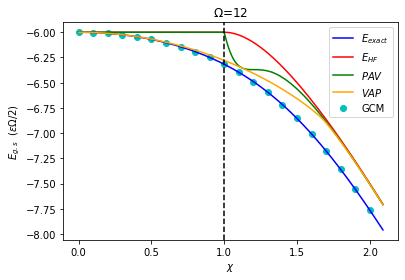

In [ ]:
plt.plot(XX,np.array(exact[0]),label='$E_{exact}$',color='b')
plt.plot(XX,np.array(HF[0]),label='$E_{HF}$',color='r')
plt.plot(XX,np.array(pav[0]),label='$PAV$',color='g')
plt.plot(XX,np.array(vap[0]),label='$VAP$',color='orange')
plt.scatter(chi,e1,label='GCM',color='c')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$  $(\epsilon\Omega/2)$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega$={Omega[0]}')
plt.legend()

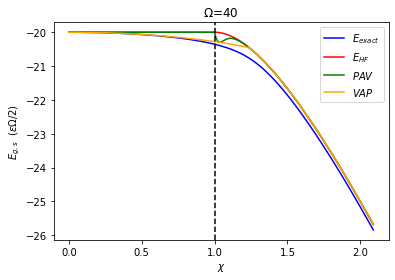

In [ ]:
plt.plot(XX,np.array(exact[1]),label='$E_{exact}$',color='b')
plt.plot(XX,np.array(HF[1]),label='$E_{HF}$',color='r')
plt.plot(XX,pav[1],label='$PAV$',color='g')
plt.plot(XX,vap[1],label='$VAP$',color='orange')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$  $(\epsilon\Omega/2)$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega$={Omega[1]}')
plt.legend()

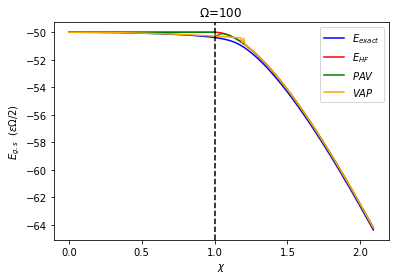

In [ ]:
plt.plot(XX,np.array(exact[2]),label='$E_{exact}$',color='b')
plt.plot(XX,np.array(HF[2]),label='$E_{HF}$',color='r')
plt.plot(XX,pav[2],label='$PAV$',color='g')
plt.plot(XX,vap[2],label='$VAP$',color='orange')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$  $(\epsilon\Omega/2)$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega$={Omega[2]}')
plt.legend()

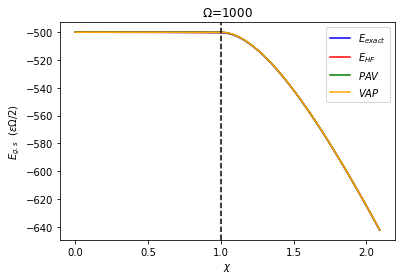

In [ ]:
plt.plot(XX,exact[3],label='$E_{exact}$',color='b')
plt.plot(XX,HF[3],label='$E_{HF}$',color='r')
plt.plot(XX,pav[3],label='$PAV$',color='g')
plt.plot(XX,vap[3],label='$VAP$',color='orange')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$  $(\epsilon\Omega/2)$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega$={Omega[3]}')
plt.legend()